In [1]:
%pip install librosa

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
'''
Please install this specific version of resampy for librosa to work without errors.
'''

'\nPlease install this specific version of resampy for librosa to work without errors.\n'

In [3]:
%pip install resampy==0.3.1

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
import soundfile
import os
import glob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import librosa
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report
import warnings; warnings.filterwarnings('ignore')

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
emotions ={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

### Data for binary classification


In [6]:
def load_extract_features(data_path):

    '''
    load_extract_features() is a function that is used to load all the audio files one at a time, compute their features and return the features as well as the target values.

    There are around 8-10 audio files which are corrupted. We hardcode zero values for such files in order to maintain consistency.

    ['calm', 'happy'] emotion data is categorized into 'positive' and  ['angry', 'fearful'] into 'negative'

    Returns:
    1. Features
    2. Binary Target Values
    '''
    final_features,target_emotions, binary_label = [],[], []
    count = 0
    
    for i in glob.glob(data_path + "/Actor_*/*.wav"): #Loop to read every file.
        
        name = os.path.basename(i)
        #We split the name of the file to understand the emotion associated with the file.
        split = name.split("-")
        #We know that the third identifier is associated with the emotion of the audio file. Hence, we use [2] as it represents the third identifier.
        emotion = emotions[split[2]]

        #Below is the code to categorize the emotions into two classes to make this a binary problem.
        if emotion in ['calm', 'happy']:
            binary_label.append(0)
        elif emotion in ['angry', 'fearful']:
            binary_label.append(1)
        else:
            continue
        
        with soundfile.SoundFile(i) as audio:
            waveform = audio.read(dtype="float32")
            sr = audio.samplerate
            
            #Below is the code to extract the Mel spectrogram features
            #128 is the standard for machine learning applications using Mel spectrograms
            m_feature = librosa.feature.melspectrogram(y=waveform, sr=sr, n_mels=128, fmax=sr / 2.0).T
            melspectrogram = np.mean(m_feature,axis=0)
            if melspectrogram.shape != (128,):
                melspectrogram = np.zeros(128)
            
            #Below is the code to extract the chromagram features
            stft_wave = librosa.stft(waveform)
            stft = np.abs(stft_wave)
            c_feature = librosa.feature.chroma_stft(S=stft, sr=sr).T
            chromagram = np.mean(c_feature,axis=0)
            
            #12 is the number of pitch classes
            if chromagram.shape != (12,):
                chromagram = np.zeros(12)
                
            features=np.array([])
            features=np.hstack((chromagram, melspectrogram))
        
            final_features.append(features)
            target_emotions.append(emotion)
            
            count += 1
            if count % 100 == 0:
                print("Processed Audio File Number: ", count)
    
    #We return the features and the binary target values.
    return np.array(final_features), np.array(binary_label)

In [8]:
#Please change the path below to the path of the folder saved on your computer.
data_path = './audio_speech_actors_01-24'
X, binary_label = load_extract_features(data_path)

Processed Audio File Number:  100
Processed Audio File Number:  200
Processed Audio File Number:  300
Processed Audio File Number:  400
Processed Audio File Number:  500
Processed Audio File Number:  600
Processed Audio File Number:  700


In [9]:
print(X)
print(binary_label)

[[5.16858757e-01 5.33194840e-01 5.29453754e-01 ... 4.02650464e-08
  8.08175571e-09 6.75256873e-09]
 [6.04014695e-01 5.90544760e-01 6.36313319e-01 ... 1.30306420e-04
  1.18871294e-05 4.47097399e-08]
 [4.65188712e-01 4.62528020e-01 4.49644387e-01 ... 4.76428212e-08
  9.07249476e-09 5.81690918e-09]
 ...
 [6.23701811e-01 5.20824969e-01 5.08405566e-01 ... 1.28668421e-06
  1.06063219e-07 8.18918444e-09]
 [6.10289574e-01 6.07244730e-01 6.01210058e-01 ... 3.32076304e-08
  8.18264390e-09 6.88534252e-09]
 [6.66881859e-01 6.45011961e-01 6.21618748e-01 ... 1.49683530e-07
  2.09078372e-08 6.57300303e-09]]
[0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 1 1 1 1 0 0 0 0 0 1 1 1 1 0 0 1 0 1 0 1 0 0
 0 1 0 1 1 1 1 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 1 1 1 1 1 1 0 0 1 1 0 0 0 1 0
 0 0 0 1 0 0 0 0 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 0 0 1 1 0 1 0 0 1 0
 0 0 1 0 0 1 0 1 0 0 1 1 1 0 1 1 1 0 0 1 1 0 1 0 0 1 0 0 0 0 0 1 1 0 1 1 1
 0 0 1 1 1 0 1 1 0 1 1 0 1 0 1 1 0 1 1 0 0 1 1 1 1 0 1 0 0 1 1 1 0 0 1 0 0
 0 1 0 0 1 0 0 0 0 0 1 1 

# a) Knn With Cross Validation to find value K:

## Split the data

In [45]:
#Split the data, 70% train, 30% test
X_train, X_test, Y_train, Y_test = train_test_split(X, binary_label, test_size=0.30, train_size=0.70, random_state=20)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(537, 140)
(231, 140)
(537,)
(231,)


## Implement KNN

In [46]:
def KNN(k, x_train, y_train, x_test):
    predictedValues = []
    for point in x_test:
        # calculate all the distances between the training set and the point
        distances = [np.power(np.linalg.norm(x - point), 2) for x in x_train]
        # find the smallest k distances
        smallestK = np.argpartition(distances, k)[:k]
        # find the corresponding labels from the smallest k distances
        y_values = y_train[smallestK]
        #Find the majority label and assign it to the prediction array
        predictedValues.append(np.bincount(y_values).argmax())

    return predictedValues

    

## Find best K with Cross Validation

In [47]:
def get_accuracy(prediction, labels):
    same_element = 0
    for i in range(len(prediction)):
        if prediction[i] == labels[i]:
            same_element += 1
    return same_element / len(prediction)

In [48]:
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
%matplotlib inline

#have the same set of rows for the PCA and normal cross validation 
num_partitions = 10
global_partitions = StratifiedKFold(n_splits=num_partitions)
indices = []
for fold, (train, test) in enumerate(global_partitions.split(X_train, Y_train)):
    indices.append((train, test))

def find_best_k():
    num_partitions = 10

    k_range = list(range(3, 35))
    k_scores = []
    best_k = 3

    for k in k_range:
        total = 0
        for (train, test) in indices:
            x_train, x_test, y_train, y_test = X_train[train], X_train[test], Y_train[train], Y_train[test]

            prediction = KNN(k, x_train, y_train, x_test)

            accuracy = get_accuracy(prediction, y_test)
            total += accuracy
        mean = total / num_partitions
        k_scores.append(mean)
        if mean > k_scores[best_k-3]:
            best_k = k

    # Visualize Results
    plt.plot(k_range, k_scores)
    plt.xlabel('Value of K for KNN')
    plt.ylabel('Cross-Validated Accuracy')

    print("Best K:" + str(best_k))

    return best_k


## Find the best k to apply to the testing set

Best K:6
CPU times: user 26.3 s, sys: 12 ms, total: 26.3 s
Wall time: 26.3 s


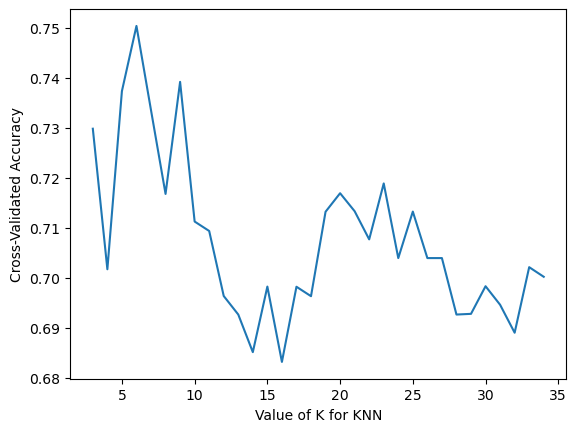

In [49]:
%%time
k = find_best_k()

## Determine accuracy and runtime of KNN

In [54]:
%%time
prediction = KNN(k, X_train, Y_train, X_test)

accuracy = get_accuracy(prediction, Y_test)

print("ACCURACY: " + str(accuracy))

ACCURACY: 0.6926406926406926
CPU times: user 426 ms, sys: 3.42 ms, total: 430 ms
Wall time: 426 ms


As you can see, when preforming cross validation on the normal data set with over 100 features, we have an accuracy of 69% while having a running time of about 426ms.

# b) Perform the PCA Approach

In [55]:
def perform_PCA(threshold):

    # 1. Find the mean ans subtract it from all the data points
    meanX = np.mean(X, axis=0)
    alteredX = X - meanX

    # 2. Calculate the covariance matrix
    covX = np.cov(alteredX, rowvar=False)

    # 3. Determine the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(covX)
    # 4. sort the eigenvalues and eigenvectors
    eigen_indices = np.argsort(eigenvalues)
    eigenvalues = eigenvalues[eigen_indices]
    eigenvectors = eigenvectors[eigen_indices]

    eigen_len = len(eigenvalues)
    eigenvalue_sum = np.sum(eigenvalues)
    selected_eigenvectors = []
    sum = 0

    # 5. starting from the largest eigenvalue, find the eigenvalues that cross the threshold
    for i in range(eigen_len-1, 0, -1):
        sum += eigenvalues[i]
        selected_eigenvectors.append(eigenvectors[i])
        if (sum/eigenvalue_sum > threshold):
            break

    # 6. and 7. For each point x, multiply it by our selected eigenvectors to determine our new mapped X
    W = np.array(selected_eigenvectors).T
    newX = [np.matmul(W.T, x-meanX) for x in X]
    return np.array(newX)


        






In [56]:
newX = perform_PCA(.96)
print(newX.shape)
print("------------------------")

X_train, X_test, Y_train, Y_test = train_test_split(newX, binary_label, test_size=0.30, train_size=0.70, random_state=20)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)


(768, 14)
------------------------
(537, 14)
(231, 14)
(537,)
(231,)


Best K:3
CPU times: user 24.3 s, sys: 8.17 ms, total: 24.3 s
Wall time: 24.3 s


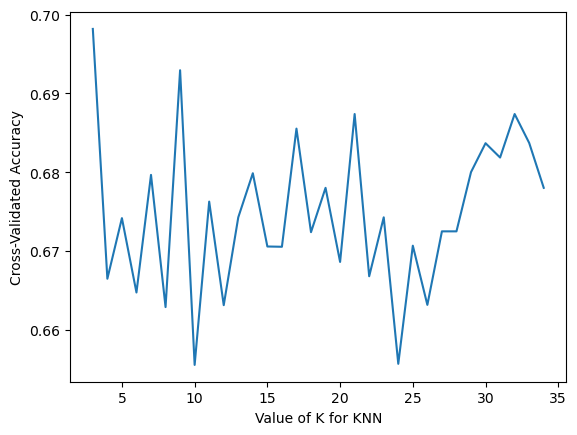

In [57]:
%%time
k = find_best_k()

In [60]:
%%time
prediction = KNN(k, X_train, Y_train, X_test)

accuracy = get_accuracy(prediction, Y_test)

print("ACCURACY: " + str(accuracy))

ACCURACY: 0.683982683982684
CPU times: user 377 ms, sys: 2.09 ms, total: 379 ms
Wall time: 375 ms


As you can see, when reducing the dimensionality of the data, we get an accuracy of around 68%, while having a runtime of around 375ms

Comparing our PCA cross validation results with the results from the original dataset, we see that the accuracy is about the same, at 68% compared to 69% for the normal dataset, even though we reduced the number of features by over 100. In addition, the runtime is much lower than the normal data set, thus we are able to acheive a similar accuracy in a shorter run time for both the testing set prediction as well as the cross validation itself.